In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
from jax import numpy as jnp
from flax import linen as nn

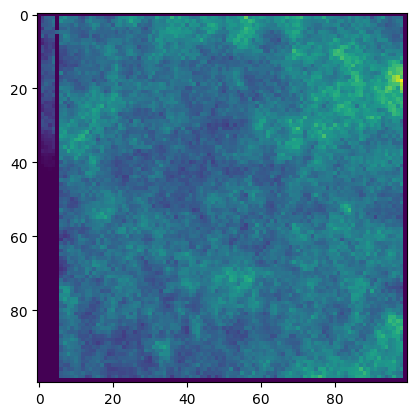

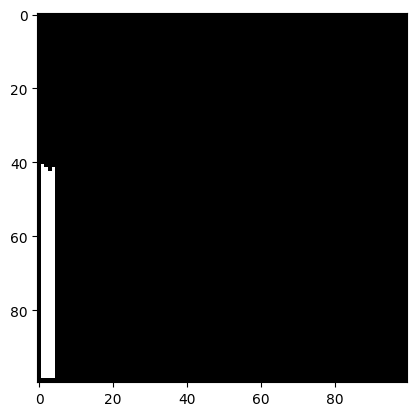

In [21]:
n_cells = 100
grid = np.zeros((n_cells, n_cells))
occupancy_map = np.zeros_like(grid)

grid[:, 0] = -1
grid[:, -1] = -1
grid[0, :] = -1
grid[-1, :] = -1

# grid[1:-1, 1:-1] = np.random.randint(-1, 2, size=(n_cells-2, n_cells-2))
grid[:,5] = -1
grid[5, 5] = 0
plt.imshow(grid, cmap='gray')
x,y = 2, 2
for i in range(1000000):
    dx, dy = np.random.randint(-1, 2, size=2)
    if grid[x+dx, y+dy] != -1:
        x += dx
        y += dy
    occupancy_map[x, y] += 1
plt.imshow(occupancy_map)
plt.show()
plt.imshow(occupancy_map<1 + grid, cmap='gray')

In [ ]:
class OccupancyNet(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(16, (3, 3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(32, (3, 3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.ConvTranspose(32, (3, 3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.ConvTranspose(16, (3, 3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.ConvTranspose(1, (3, 3), padding='SAME')(x)
        return x

# Prepare the data
input_data = occupancy_map[None, ..., None]  # Add batch and channel dimensions
target_data = grid[None, ..., None]  # Add batch and channel dimensions

# Define a loss function
def loss_fn(params, model, x, y):
    preds = model.apply(params, x)
    return jnp.mean((preds - y) ** 2)

# Initialize the model
model = OccupancyNet()
variables = model.init(jax.random.PRNGKey(0), input_data)
params = variables['params']

# Define an optimizer
optimizer = jax.experimental.optimizers.adam(1e-3)
opt_state = optimizer.init(params)

# Training loop
for step in range(1000):
    loss, grads = jax.value_and_grad(loss_fn)(params, model, input_data, target_data)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = jax.experimental.optimizers.apply_updates(params, updates)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss}")